In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [2]:
# read in dataset Jill
dset = pd.read_csv('SapnaSharma2.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

16015
26.691666666666666


In [3]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
#d = pd.DataFrame(data = dset[0:25000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/10) # add timestamp assuming 10 samples / second
#print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

d['bmav'] = d['belly'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])
d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])
d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

d['brmav'] = d['brlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['bfmav'] = d['bflast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['brfmav'] = (d['brmav']+ d['bfmav'])/2

#Breathing rate averages Chest and Belly
d['cbrfmav'] = d['brfmav']*0.1+d['rfmav']*0.9

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

In [4]:
f = d

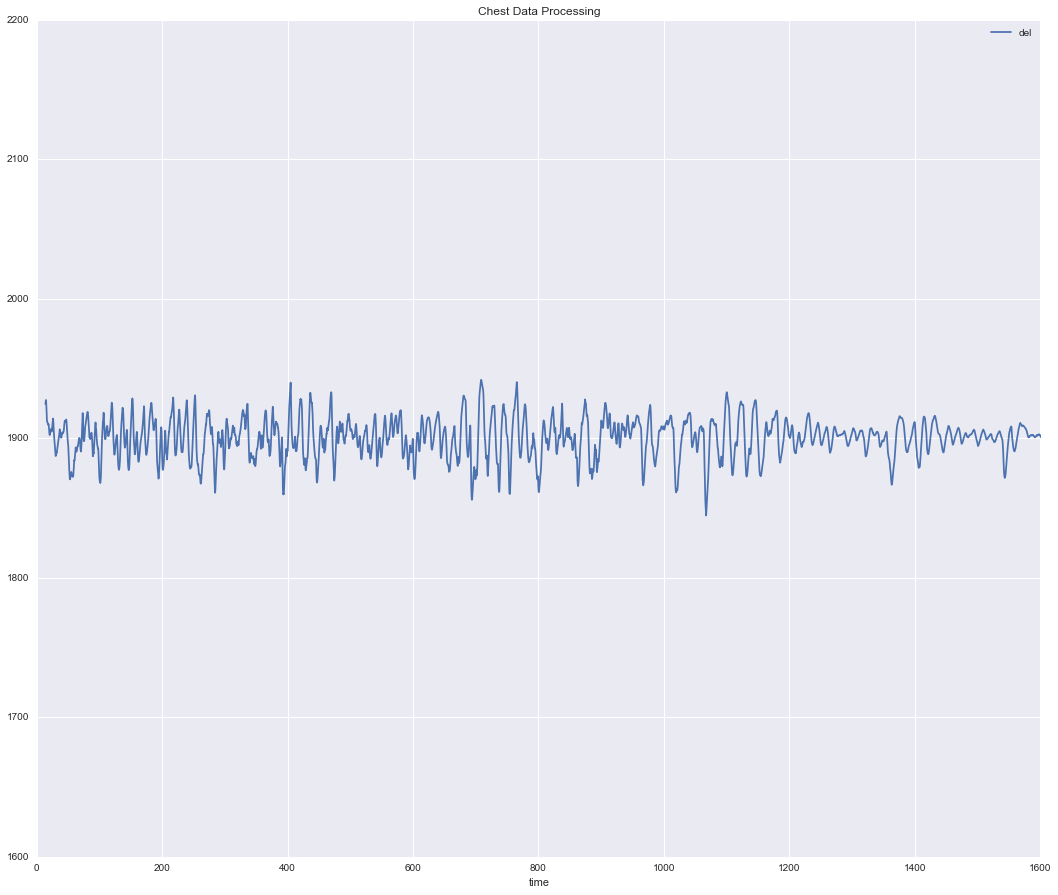

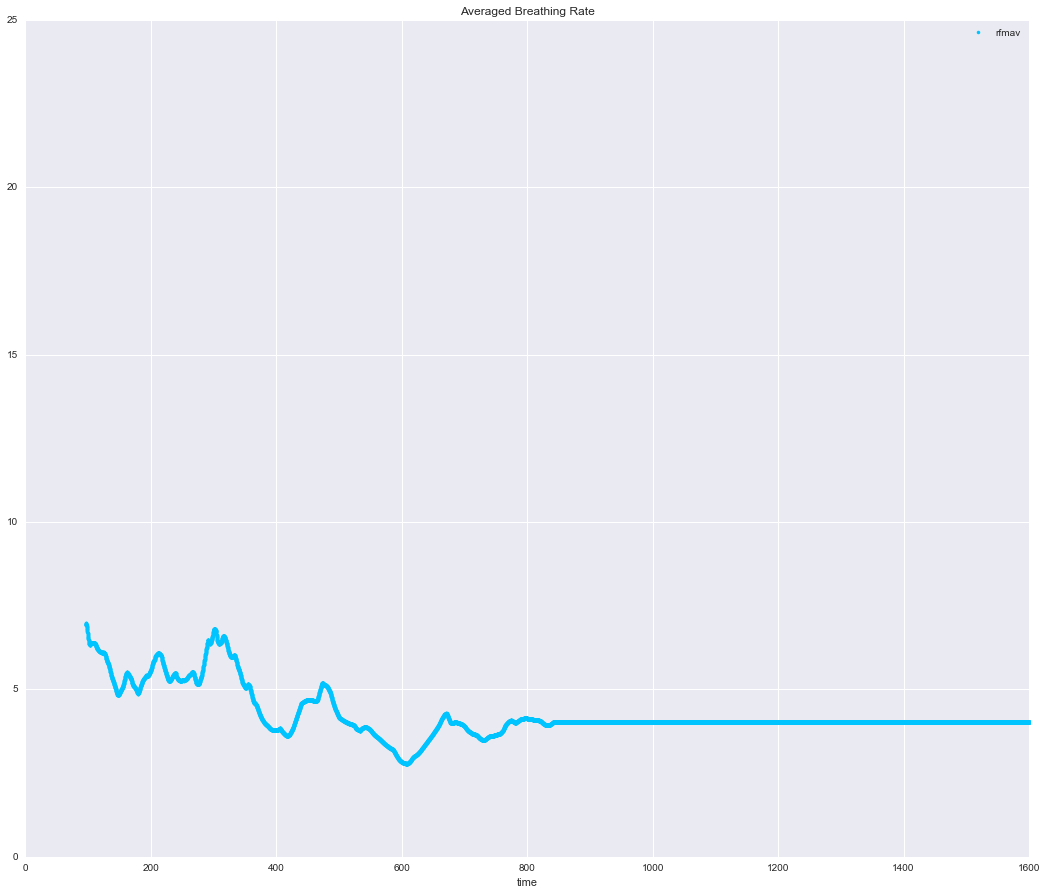

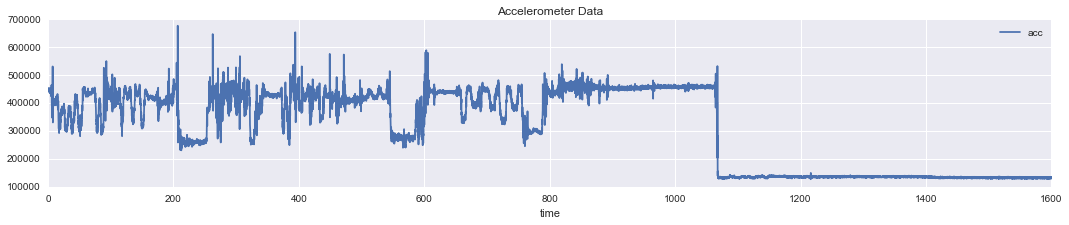

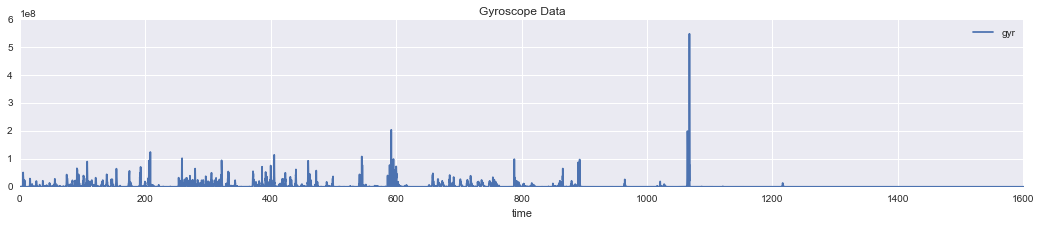

In [5]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [6]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy    gz    time  ...   \
0          0   3143   2640  199  455  448  -504   296   256     0.0  ...    
1000    1000   3128   2739  236  423  444 -1635  1801    86   100.0  ...    
2000    2000   3139   2708   96   88  635  2936   730  -327   200.0  ...    
3000    3000   3160   2769  -13 -210  599 -2619   989   149   300.0  ...    
4000    4000   3128   2725   46  123  604 -6730  5379  1336   400.0  ...    
5000    5000   3184   2882   12  -74  668  -347   402   385   500.0  ...    
6000    6000   3140   2765  -68 -116  616  5377 -3445  -209   600.0  ...    
7000    7000   3128   2791  225  446  451    84   -84   168   700.0  ...    
8000    8000   3124   2735  224  497  367   597  -245   244   800.0  ...    
9000    9000   3161   2827  137  435  492    33   -88   357   900.0  ...    
10000  10000   3219   2877   80  359  566    55   -21   209  1000.0  ...    
11000  11000   3229   2828   63   78 -349   -15   -49   197  1100.0  ...    

In [7]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fmav,rfmav,brmav,bfmav,brfmav,cbrfmav,acc,gyr,b1,b2
0,0,3143,2640,199,455,448,-504,296,256,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,447330,407168,1900,1600
1,1,3147,2629,188,441,460,-393,710,218,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,441425,706073,1900,1600
2,2,3149,2634,199,451,455,-640,424,304,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,450027,681792,1900,1600
3,3,3150,2620,188,444,462,53,-198,235,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,445924,97238,1900,1600
4,4,3153,2632,187,451,464,-177,-415,83,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,453666,210443,1900,1600
5,5,3153,2636,193,447,463,8,-488,321,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,451427,341249,1900,1600
6,6,3158,2648,193,447,462,60,-264,123,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,450502,88425,1900,1600
7,7,3155,2658,191,448,457,-26,-486,130,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,446034,253772,1900,1600
8,8,3157,2663,204,444,459,-122,-306,139,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,449433,127841,1900,1600
9,9,3158,2666,207,443,455,-50,-190,219,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,446123,86561,1900,1600
